# 3. Models for global demand: time series forecasting

**Time series forecasting** help to predict the future values of demand based on previous known values, it is used when the dependend variable varies over time

There are 4 main components that define a Time series:
1. Trend: upward and downward movement of the demand over a period of time
2. Seasonality: seasonal variances of the data
3. Residuals: noise - random variations
4. Cyclicity: the behavior is repeated after an interval of time

## 3.1. Analyzing the time series

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import datetime
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [33]:
#Import the data we created in the first notebook
rides_per_hour = pd.read_csv('movements_grouped.csv')

In [34]:
rides_per_hour = rides_per_hour[['datetime', 'date', 'weekday', 'hour',  'time', 'month', 'is_holiday_x', 'rides', 'year', 'is_weekend']]

In [35]:
rides_per_hour.set_index('datetime', inplace=True)
rides_per_hour.sort_index(inplace=True)

In [36]:
rides_per_hour['weekday'] = rides_per_hour['weekday'].astype('category')

In [6]:
rides_per_hour = rides_per_hour[rides_per_hour['year']==2021]

### Autocorrelation plots

In [37]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

###### Autocorrelation plot (ACF)

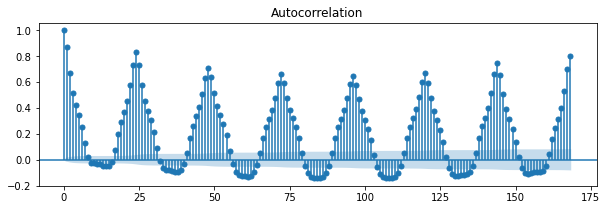

In [38]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_acf(rides_per_hour.rides, ax=ax, lags=7*24)
plt.show()

###### Partial Autocorrelation Plot (ACF)

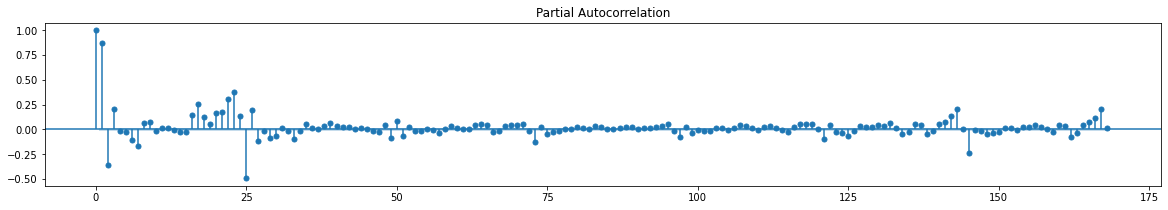

In [39]:
fig, ax = plt.subplots(figsize=(20, 3))
plot_pacf(rides_per_hour.rides, ax=ax, lags=7*24)
plt.show()

The autocorrelation and partial autocorrelation plots show a clear association between one hour's demand and previous hours, as well as between one hour's demand and the same hour's demand on previous days. **This type of correlation is an indication that autoregressive models can work well.**


### Adding lag values we will use for the model

We are going to use the lag values of the variable rides as predictors in our machine learning models, and also we are going to use them for our naive model. We are going to consider the following lags:

- rides lag 7: 7 days before at the same hour
- rides lag 1: 1 day before at the same hour
- rides lag 2: 2 days before at the same hour
- rides lag 1 month: 1 month before at the same hour
- rides lag 12 hours

In [40]:
rides_per_hour['rides_lag_7'] = rides_per_hour['rides'].shift(7*24)
rides_per_hour['rides_lag_1'] = rides_per_hour['rides'].shift(1*24)
rides_per_hour['rides_lag_2'] = rides_per_hour['rides'].shift(2*24)
rides_per_hour['rides_lag_1_month'] = rides_per_hour['rides'].shift(30*24)
rides_per_hour['rides_lag_12_hours'] = rides_per_hour['rides'].shift(12)

In [42]:
rides_per_hour

,date,weekday,hour,time,month,is_holiday_x,rides,year,is_weekend,rides_lag_7,rides_lag_1,rides_lag_2,rides_lag_1_month,rides_lag_12_hours
datetime,,,,,,,,,,,,,,
2018-12-31 23:00:00,2018-12-31,Monday,23,23:00:00,12,0,176,2018,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 00:00:00,2019-01-01,Tuesday,0,00:00:00,1,1,254,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 01:00:00,2019-01-01,Tuesday,1,01:00:00,1,1,169,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 02:00:00,2019-01-01,Tuesday,2,02:00:00,1,1,105,2019,0,NaN,NaN,NaN,NaN,NaN
2019-01-01 03:00:00,2019-01-01,Tuesday,3,03:00:00,1,1,83,2019,0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,2021-06-30,Wednesday,19,19:00:00,6,0,813,2021,0,814.0,749.0,691.0,610.0,815.0
2021-06-30 20:00:00,2021-06-30,Wednesday,20,20:00:00,6,0,552,2021,0,559.0,581.0,507.0,224.0,565.0
2021-06-30 21:00:00,2021-06-30,Wednesday,21,21:00:00,6,0,571,2021,0,615.0,482.0,400.0,205.0,509.0


###### Let's analyze the correlation between our variables

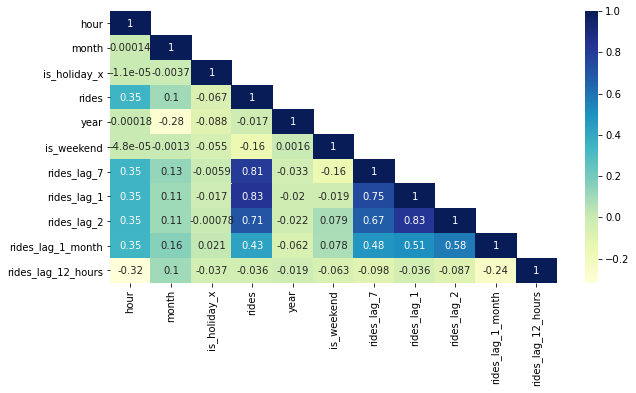

In [43]:
corr_matrix = rides_per_hour.corr()
fig = plt.figure(figsize=(10, 5))

mask = np.array(corr_matrix)
mask[np.tril_indices_from(mask)] = False

sns.heatmap(corr_matrix, mask = mask, annot=True, cbar=True,cmap="YlGnBu")
plt.show()

From the correlation matrix we can see that the variable rides we want to predict is highly correlated with.
- rides_lag_7 (demand 7 days before at the same time): coefficient 0.81
- rides_lag_1 (demand 1 day before at the same hour): coefficient 0.83
- rides_lag_2 (demand 2 days before at the same hour): coefficient 0.71

The variable rides is also correlated with:
- rides_lag_1_month (demand one month before at the same hour): coefficient 0.43
- hour: coefficient 0.35

##### Check if the data is stationary

In [44]:
from statsmodels.tsa.stattools import adfuller

To check if the data is stationary we are going to perform the **Dickey-Fuller test**: This test is used to try the null hypotesis: time-series data is non-stationary. It calculates the p-value and compareit with a threshold value of 0.05. If the p-value is lower than this level, data is stationary

In [45]:
df_test=adfuller(rides_per_hour['rides'], autolag='AIC', regression = 'ct')
df_test_results = pd.Series(df_test[0:4], index = ['Test statistic', 'p-value', 'Number of lags', 'Number observations'])
for key,value in df_test[4].items():
    df_test_results['Critical value (%s)' %key]=value

In [46]:
#Results of Dickey-Fuller test
df_test_results

Test statistic         -8.521028e+00
p-value                 4.488707e-12
Number of lags          4.700000e+01
Number observations     2.184100e+04
Critical value (1%)    -3.959185e+00
Critical value (5%)    -3.410691e+00
Critical value (10%)   -3.127168e+00
dtype: float64

Conclusions: we reject the null hypotesis and conclude that our **time series is stationary**

## 3.2. Naive model

We are going to create a naive model that will serve us as a baseline to compare it with the models we are going to build. 

We have just seen that the variable rides is highly correlated with the variable rides_lag_7, which is the demand of bikes at the same hour the week before, so for our naive model we are going to consider that the demand is the same as rides_lag_7

In [47]:
rides_naive=rides_per_hour.dropna(subset=['rides_lag_7'])

In [48]:
rides_naive.columns

Index(['date', 'weekday', 'hour', 'time', 'month', 'is_holiday_x', 'rides',
       'year', 'is_weekend', 'rides_lag_7', 'rides_lag_1', 'rides_lag_2',
       'rides_lag_1_month', 'rides_lag_12_hours'],
      dtype='object')

In [49]:
train_end = 24*14 #14 days
train = rides_naive[:-train_end]
test = rides_naive[-train_end:]
X_train, y_train = train['rides_lag_7'], train['rides']
X_test, y_test = test['rides_lag_7'], test['rides']

In [50]:
predictions = X_test
demand = y_test

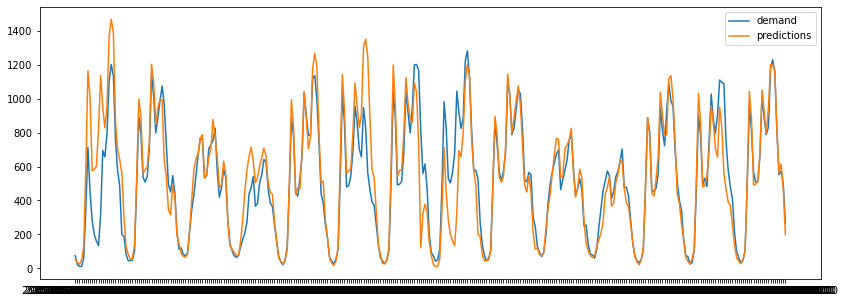

In [51]:
#plot demand vs predictions
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

###### Evaluating model

We are going to create a dataframe where we are going to add the results of all the models we are going to try. In this dataframe we are going to add the metrics:

- MSE
- MAE
- RMSE
- R2

In [52]:
from sklearn import metrics
def calculate_metrics(forecast,demand):
    mse = metrics.mean_squared_error(forecast,demand)
    mae = metrics.mean_absolute_error(forecast,demand)
    rmse = np.sqrt(metrics.mean_squared_error(forecast,demand))
    r2 = metrics.r2_score(forecast,demand)
    return mse, mae, rmse, r2

In [53]:
evaluation_models = pd.DataFrame(columns=["model", "MSE", "MAE", "RMSE", "R2"])

In [54]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'naive', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)


In [55]:
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749


## 3.3. Machine Learning Models

Advantages of using Machine learning methods for forecasting.
* Ease of including exogenous variables in addition to autoregressive variables
* Allows the incorporation of non-linear behaviors
* High scalability, useful when large amount of data is available

There are also some disadvantages for this:

* Restructuring the data to fit a regression problem
* Iterative processes are needed, each prediction uses the previous predictions
* Validation requires specific strategies. Traditional cross validation does not work

The forecast in a time series can be decomposed in two parts:
    
    Forecast = patterns (explained variance) + unexplained variance
    
* Patterns: it has a repetitive character over time (trend, seasonality, cyclical values)
* Unexplained variance: influences the target variable but cannot be explained by the past

The higher the importance of the patterns, the higher the probability of creating autorregresive forecasting models. The higher the importance of the unexplained variance requires to incorporate additional variables to the model, to help to understand the observed values

It's importat to control the bias and variance of the model. Small trees (few braches) have low variance but fail to represent well the relationship between variables (high bias). On the other hand, large trees are very close to the training data, so they will propably have high variance. We need to control the balance between bias and variance this can be solved with ensemble methods.

Ensemble methods combine multiple models in a new one, with the aim of balancing bias and variance. Typeas of ensembling methods:

1. Bagging: multiple models are fitted, each with a different subset of the training data. As a final value, the mean of all predictions is taken. Random Forest belong to this category
2. Boosting: multiple simple models are adjusted sequentially, so each model learns from the errors of the previous one. Finally, the mean of all predictions is taken. Gradient Boosting belong to this category

We need to transform the temporal series in a matrix, where each value is related to the precedent lags

#### 3.3.1. Random Forest Ensemble

Random Forest is a non parametric method, so no specific distribution is required. Also, this type of models require less data cleaning and preprocessing compared to other statistical methods, this models do not require standarization.
They are not greatly influenced by outliers.

First we need to prepare the data for the model. 

To take into account the day of the week we are going to perform a One-hot encoding, this process takes categorical variables and converts it to numerical representation without an arbitrary ordering.

We are going to perform the One Hot Encoding for the columns:

- Weekday
- Month
- Hour

This way the model is giving the same importances to all the variables

In [56]:
#Libraries
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from skforecast.ForecasterAutoreg import ForecasterAutoreg
import warnings
warnings.filterwarnings('ignore')
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster

In [57]:
#One hot encoding for categorical variables
rides_per_hour = pd.get_dummies(rides_per_hour, columns=['weekday', 'hour', 'month'])

In [58]:
rides_per_hour.columns

Index(['date', 'time', 'is_holiday_x', 'rides', 'year', 'is_weekend',
       'rides_lag_7', 'rides_lag_1', 'rides_lag_2', 'rides_lag_1_month',
       'rides_lag_12_hours', 'weekday_Friday', 'weekday_Monday',
       'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday',
       'weekday_Tuesday', 'weekday_Wednesday', 'hour_0', 'hour_1', 'hour_2',
       'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21',
       'hour_22', 'hour_23', 'month_1', 'month_2', 'month_3', 'month_4',
       'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10',
       'month_11', 'month_12'],
      dtype='object')

In [59]:
#We save the columns we are using as predictors in columns for model and the target we want to predict in target
columns_for_model = [column for column in rides_per_hour.columns
                      if column.startswith(('weekday', 'hour', 'month'))]

columns_for_model.extend(['is_holiday_x', 'is_weekend'])

target = 'rides'

In [60]:
rides_per_hour_models = rides_per_hour.dropna(subset = ['rides_lag_7'])

In [61]:
rides_per_hour_models

,date,time,is_holiday_x,rides,year,is_weekend,rides_lag_7,rides_lag_1,rides_lag_2,rides_lag_1_month,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
datetime,,,,,,,,,,,,,,,,,,,,,
2019-01-07 23:00:00,2019-01-07,23:00:00,1,132,2019,0,176.0,202.0,218.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 00:00:00,2019-01-08,00:00:00,0,64,2019,0,254.0,160.0,238.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 01:00:00,2019-01-08,01:00:00,0,38,2019,0,169.0,88.0,164.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 02:00:00,2019-01-08,02:00:00,0,21,2019,0,105.0,66.0,107.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2019-01-08 03:00:00,2019-01-08,03:00:00,0,25,2019,0,83.0,63.0,72.0,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-30 19:00:00,2021-06-30,19:00:00,0,813,2021,0,814.0,749.0,691.0,610.0,...,0,0,0,1,0,0,0,0,0,0
2021-06-30 20:00:00,2021-06-30,20:00:00,0,552,2021,0,559.0,581.0,507.0,224.0,...,0,0,0,1,0,0,0,0,0,0
2021-06-30 21:00:00,2021-06-30,21:00:00,0,571,2021,0,615.0,482.0,400.0,205.0,...,0,0,0,1,0,0,0,0,0,0


In [62]:
rides_per_hour_models['rides_lag_7'] = rides_per_hour_models['rides_lag_7'].astype(int)
rides_per_hour_models['rides_lag_1'] = rides_per_hour_models['rides_lag_1'].astype(int)

In [66]:
#Verification that the temporal series is complete
(rides_per_hour.index==pd.date_range(start = rides_per_hour.index.min(),
                                   end = rides_per_hour.index.max(),
                                   freq='1H')
).all()

True

In [67]:
#Division of the dataset in train and test
train_end = 14*24 #14 days
train = rides_per_hour_models[:-train_end]
test = rides_per_hour_models[-train_end:]

In [68]:
X_train, y_train = train[columns_for_model], train[target]
X_test, y_test = test[columns_for_model], test[target]

A ForecasterAutoreg is created and trained from a RandomForestRegressor and a time window of 24*7 lags, using the past 7 days demand at the same hour as predictors, because we saw in the correlation matrix that the demand is correlated with these lags

In [69]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags = [24,24*2,24*3,24*4,24*5,24*6,24*7])

forecaster.fit(y_train)
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [0, 21384] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': T

In [70]:
#Prediction of test
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
predictions

0       77.52
1       38.63
2       27.46
3       45.47
4      113.69
        ...  
331    832.13
332    569.46
333    507.85
334    416.04
335    218.08
Name: pred, Length: 336, dtype: float64

In [72]:
demand = y_test
demand = demand.reset_index()
demand = demand['rides']
demand

0       75
1       22
2       11
3       11
4       58
      ... 
331    813
332    552
333    571
334    499
335    264
Name: rides, Length: 336, dtype: int64

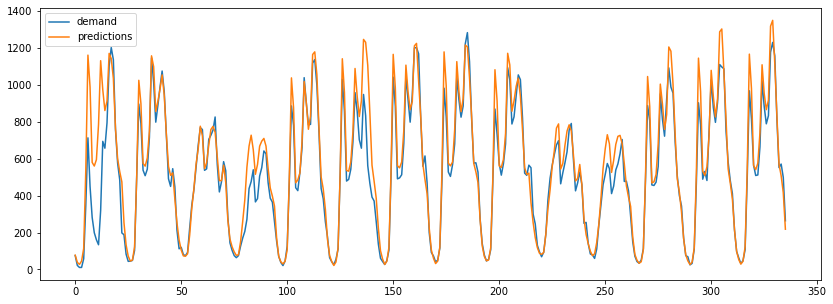

In [73]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [74]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'ForecastAutoreg', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)


In [75]:
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,ForecastAutoreg,14190.843147,69.943988,119.125325,0.887879


Using the forecaster autorregresor with a Random Forest we have reduced the mse to 43%. We also improved all the metrics: MSE, MAE, RMSE and R2.

### Hyperparameters

We are going to search for the best hyperparameters for the model and the number of lags required, for this we are going to perform a grid search

In [76]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags =24*7)

#Lags used as predictors
possible_lags = [24*7, 24*1]

#hyperparameters of regressor
param_grid = {'n_estimators':[100,500],
             'max_depth': [3,5,10]}

grid_results = grid_search_forecaster(forecaster = forecaster,
                                     y = y_train,
                                     param_grid = param_grid,
                                     lags_grid = possible_lags,
                                     steps = 24,
                                     refit = False,
                                     metric = 'mean_squared_error',
                                     initial_train_size=int(len(X_train)*0.5),
                                     fixed_train_size = False,
                                     return_best=True,
                                     verbose=False
                                     )

loop param_grid:   0%|                                              | 0/6 [00:00<?, ?it/s]

Number of models compared: 12



loop lags_grid: 100%|█████████████████████████████████████| 2/2 [56:45<00:00, 1702.57s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168] 
  Parameters: {'max_depth': 10, 'n_estimators': 100}
  Backtesting metric: 27989.583686102673



In [77]:
#Results of the grid search
grid_results

,lags,params,metric,max_depth,n_estimators
4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",27989.583686,10,100
5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",28265.023964,10,500
3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",35396.643364,5,500
2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",35832.724460,5,100
11,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 500}",38494.623505,10,500
10,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 10, 'n_estimators': 100}",39094.980347,10,100
9,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 500}",67504.288774,5,500
1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 500}",68005.898694,3,500
0,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 3, 'n_estimators': 100}",68481.216770,3,100
8,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","{'max_depth': 5, 'n_estimators': 100}",70320.263214,5,100


Best results are the ones that use a lag and the hyperparameters:
* max_depth: 10
* n_estimators: 500

##### Final model

Once we've found the best combination of hyperparameters, we train a new ForecasterAutoreg and plot the results

In [78]:
regressor = RandomForestRegressor(max_depth=10,n_estimators =50, random_state=123)
forecaster = ForecasterAutoreg(regressor=regressor,
                              lags=24*7)
forecaster.fit(y=y_train)

In [79]:
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

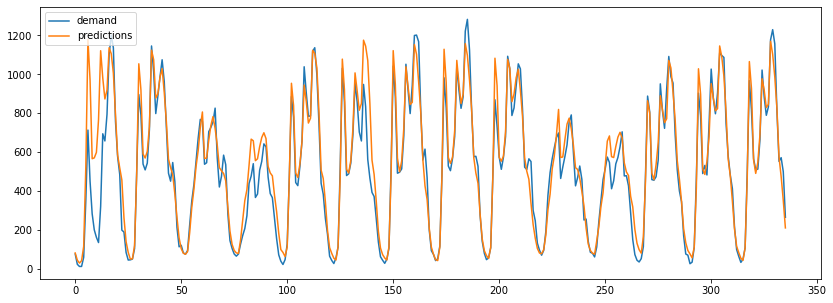

In [80]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [87]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'ForecastAutoreg grid search', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,ForecastAutoreg,14190.843147,69.943988,119.125325,0.887879
2,ForecastAutoreg,13062.952660,69.379588,114.293275,0.880072
3,ForecastAutoreg grid search,13062.952660,69.379588,114.293275,0.880072


With the grid search, we have improved our model by 8% in terms of MSE.

Now we are going to evaluate the importance of the predictors

In [88]:
predictors_importance = forecaster.get_feature_importance()
predictors_importance = predictors_importance.sort_values(by='importance', ascending = False)
predictors_importance = predictors_importance.head()

In [90]:
predictors_importance

,feature,importance
0,lag_1,0.651705
167,lag_168,0.161130
23,lag_24,0.101823
166,lag_167,0.008942
22,lag_23,0.005712


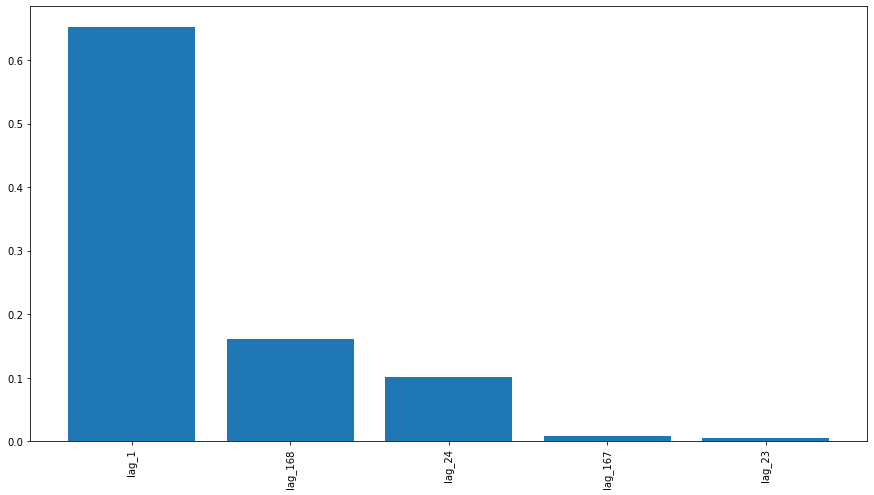

In [89]:
plt.figure(figsize=(15,8))
plt.bar(predictors_importance['feature'], height = predictors_importance['importance']);
plt.xticks(rotation=90);

The most influential variable in the model is the previous day's demand at the same time (lag 1), with an importance of the 65%

##### Adding exogenous variables to the model

For the previous model we only take into account the lag values as predictors, now we are going to add exogenous variables, that we know in advance.

We are going to add the variables:

- Hour 
- Month
- is_weekend
- weekday

In [92]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                            lags = [24, 24*7])
forecaster.fit(y = y_train, exog = X_train[columns_for_model])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: True 
Type of exogenous variable: <class 'pandas.core.frame.DataFrame'> 
Exogenous variables names: ['weekday_Friday', 'weekday_Monday', 'weekday_Saturday', 'weekday_Sunday', 'weekday_Thursday', 'weekday_Tuesday', 'weekday_Wednesday', 'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'month_1', 'month_2', 'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9', 'month_10', 'month_11', 'month_12', 'is_holiday_x', 'is_weekend'] 
Training range: [0, 21384] 
Training index type: RangeIndex 
Training index frequency: 1 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 'aut

In [93]:
#Prediction of test
predictions = forecaster.predict(steps = len(X_test), exog = X_test[columns_for_model])
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

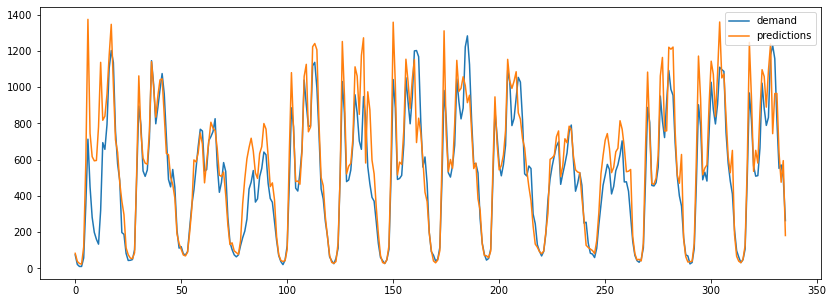

In [94]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [95]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'ForecastAutoreg with exog. variables', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,ForecastAutoreg,14190.843147,69.943988,119.125325,0.887879
2,ForecastAutoreg,13062.952660,69.379588,114.293275,0.880072
3,ForecastAutoreg grid search,13062.952660,69.379588,114.293275,0.880072
4,ForecastAutoreg with exog. variables,22295.132267,99.223988,149.315546,0.825744


This model with exogenous variables has worse results than the previous models, then we will perform a grid search to find the best hyperparameters of the model and improve the metrics.

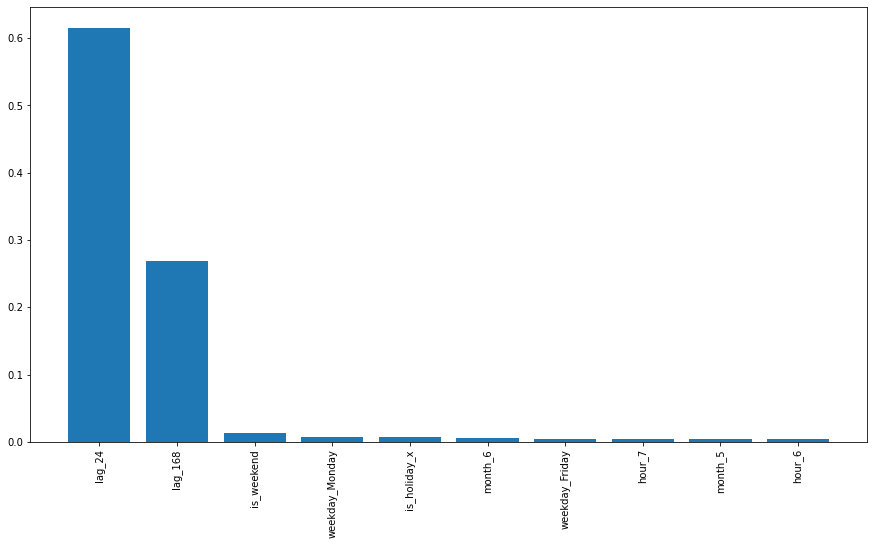

In [96]:
predictors_importance = forecaster.get_feature_importance()
predictors_importance = predictors_importance.sort_values(by='importance', ascending = False)
predictors_importance = predictors_importance.head(10)

plt.figure(figsize=(15,8))
plt.bar(predictors_importance['feature'], height = predictors_importance['importance']);
plt.xticks(rotation=90);

###### Grid search to find the best combination of hyperparameters

In [98]:
forecaster = ForecasterAutoreg(regressor = RandomForestRegressor(random_state=123),
                              lags = [24*7])
#Number of lags used as predictors
lags_grid = [[24,24*7], [24*7]]

#Regressor hyperparameters
param_grid = {'n_estimators':[100,200,500],
             'max_depth': [3,5,10]}

#Grid search
grid_seach = grid_search_forecaster(forecaster = forecaster,
                                   y = train['rides'],
                                   exog = train[columns_for_model],
                                   param_grid = param_grid,
                                   lags_grid = lags_grid,
                                   steps = 24,
                                   refit = False,
                                   metric = 'mean_squared_error',
                                   initial_train_size = int(len(train)*0.25),
                                   fixed_train_size=False,
                                   return_best=True,
                                   verbose=False)

loop param_grid:   0%|                                              | 0/9 [00:00<?, ?it/s]

Number of models compared: 18



loop lags_grid: 100%|███████████████████████████████████| 2/2 [1:20:34<00:00, 2417.35s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24 168] 
  Parameters: {'max_depth': 5, 'n_estimators': 100}
  Backtesting metric: 22184.00569561374



In [100]:
grid_seach

,lags,params,metric,max_depth,n_estimators
3,"[24, 168]","{'max_depth': 5, 'n_estimators': 100}",22184.005696,5,100
4,"[24, 168]","{'max_depth': 5, 'n_estimators': 200}",22348.191738,5,200
5,"[24, 168]","{'max_depth': 5, 'n_estimators': 500}",22461.213426,5,500
8,"[24, 168]","{'max_depth': 10, 'n_estimators': 500}",22967.883515,10,500
6,"[24, 168]","{'max_depth': 10, 'n_estimators': 100}",23013.582041,10,100
7,"[24, 168]","{'max_depth': 10, 'n_estimators': 200}",23141.271652,10,200
1,"[24, 168]","{'max_depth': 3, 'n_estimators': 200}",27208.413391,3,200
2,"[24, 168]","{'max_depth': 3, 'n_estimators': 500}",27345.549048,3,500
0,"[24, 168]","{'max_depth': 3, 'n_estimators': 100}",27346.208571,3,100
14,[168],"{'max_depth': 5, 'n_estimators': 500}",42232.664186,5,500


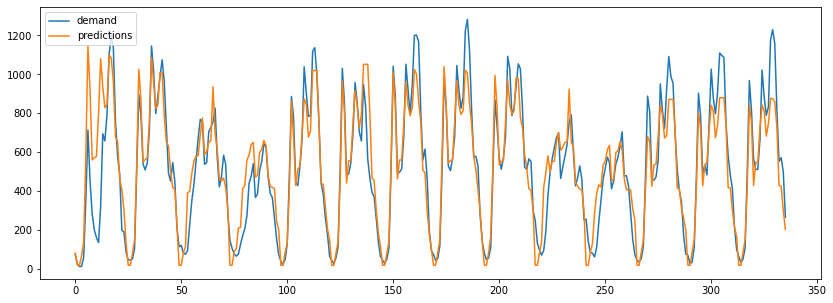

In [102]:
#Prediction of test
predictions = forecaster.predict(steps = len(X_test), exog = X_test[columns_for_model])
predictions = predictions.reset_index()
predictions = predictions['pred']
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [103]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'ForecastAutoreg with exog. variables grid search', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,24746.330357,92.889881,157.309664,0.801749
1,ForecastAutoreg,14190.843147,69.943988,119.125325,0.887879
2,ForecastAutoreg,13062.952660,69.379588,114.293275,0.880072
3,ForecastAutoreg grid search,13062.952660,69.379588,114.293275,0.880072
4,ForecastAutoreg with exog. variables,22295.132267,99.223988,149.315546,0.825744
5,ForecastAutoreg with exog. variables grid search,18056.844368,93.056430,134.375758,0.796471


Adding exogenous variables we improved our metrics, but the results with the Random forest without exogenous variables provided better results

#### 3.3.2. Extreme Gradient Boosting: XGBoost

A Gradient Boosting Decision Trees (GBDT) is a decision tree ensemble learning algorithm similar to random forest, it can be used for classification and regression. Ensemble learning algorithms combine multiple machine learning algorithms to obtain a better model.

GBDT, as Random Forest,  build a model consisting of multiple decision trees. The difference is in how the trees are built and combined.

GBDTs iteratively train an ensemble of shallow decision trees, with each iteration using the error residuals of the previous model to fit the next model. The final prediction is a weighted sum of all of the tree predictions

As a first approach to this model, we are going to use the lag values of the variable 'rides' to predict future values, and then we will include exogenous variables

In [115]:
from xgboost import XGBRegressor

In [116]:
forecaster = ForecasterAutoreg(regressor = XGBRegressor(random_state=123),
                              lags = [24, 24*7])
forecaster

ForecasterAutoreg 
Regressor: XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, predictor=None, random_state=123,
             reg_alpha=None, reg_lambda=None, ...) 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'object

In [131]:
#Grid search to find best hyperparameters

#regressor parameters
param_grid = {'n_estimators': [100,500],
             'max_depth': [3,5,10],
             'learning_rate': [0.01,0.1]}

#number of lags
lags_grid = [[24, 24*7]]

grid_search = grid_search_forecaster(forecaster = forecaster,
                                    y = y_train,
                                    param_grid=param_grid,
                                    lags_grid = lags_grid,
                                    steps = 24,
                                    refit=False,
                                    metric = 'mean_squared_error',
                                    initial_train_size = len(y_train)-1,
                                    return_best = True,
                                    verbose=False)

loop param_grid:   8%|███                                  | 1/12 [00:00<00:01,  5.91it/s]

Number of models compared: 12



loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:10<00:00, 10.38s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24 168] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 192.02475787699223



In [132]:
grid_search.head()

,lags,params,metric,learning_rate,max_depth,n_estimators
1,"[24, 168]","{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",192.024758,0.01,3.0,500.0
6,"[24, 168]","{'learning_rate': 0.1, 'max_depth': 3, 'n_esti...",284.996385,0.10,3.0,100.0
3,"[24, 168]","{'learning_rate': 0.01, 'max_depth': 5, 'n_est...",334.914126,0.01,5.0,500.0
9,"[24, 168]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",424.542583,0.10,5.0,500.0
8,"[24, 168]","{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",2105.971870,0.10,5.0,100.0


###### Backtesting

To evaluate the predictive capacity of the model, we are going to use the backtesting forecaster, so we can simulate the prediction process each 24 hours

In [138]:
#Backtesting
metric, predictions = backtesting_forecaster(forecaster = forecaster,
                                            y = y_train,
                                            initial_train_size = len(y_train)-1,
                                            steps = 24,
                                            refit = False,
                                            metric = 'mean_squared_error',
                                            verbose = False)

In [143]:
predictions = forecaster.predict(steps = len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
predictions

0      868.549377
1      498.908722
2      542.031616
3      556.745178
4      739.091736
          ...    
204    595.858093
205    476.988770
206    456.316772
207    404.877655
208    349.216156
Name: pred, Length: 209, dtype: float64

In [144]:
demand

0      857
1      479
2      488
3      543
4      690
      ... 
204    813
205    552
206    571
207    499
208    264
Name: rides, Length: 209, dtype: int64

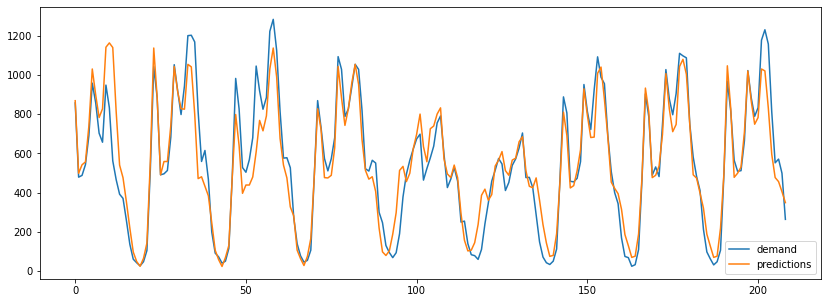

In [145]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [153]:
predictions

0      868.549377
1      498.908722
2      542.031616
3      556.745178
4      739.091736
          ...    
204    595.858093
205    476.988770
206    456.316772
207    404.877655
208    349.216156
Name: pred, Length: 209, dtype: float64

In [154]:
demand

0      857
1      479
2      488
3      543
4      690
      ... 
204    813
205    552
206    571
207    499
208    264
Name: rides, Length: 209, dtype: int64

In [152]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'XGBoost', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,23121.392344,89.478469,152.057201,0.810537
1,ForecastAutoreg,7723.660588,59.293636,87.884359,0.934986
2,ForecastAutoreg,8386.312352,62.880608,91.576811,0.926742
3,ForecastAutoreg,8386.312352,62.880608,91.576811,0.926742
4,ForecastAutoreg with exog. variables,10395.294518,65.325610,101.957317,0.895500
5,ForecastAutoreg with exog. variables,8589.378326,61.772859,92.678899,0.923244
6,LGBM,13962.583424,81.443799,118.163376,0.841084
7,XGBoost,13753.531199,80.988119,117.275450,0.842267
8,XGBoost,29588.740439,109.275520,172.013780,0.785130
9,XGBoost,13753.531199,80.988119,117.275450,0.842267


##### Adding exogenous variables

In [155]:
columns_for_model

['weekday_Friday',
 'weekday_Monday',
 'weekday_Saturday',
 'weekday_Sunday',
 'weekday_Thursday',
 'weekday_Tuesday',
 'weekday_Wednesday',
 'hour_0',
 'hour_1',
 'hour_2',
 'hour_3',
 'hour_4',
 'hour_5',
 'hour_6',
 'hour_7',
 'hour_8',
 'hour_9',
 'hour_10',
 'hour_11',
 'hour_12',
 'hour_13',
 'hour_14',
 'hour_15',
 'hour_16',
 'hour_17',
 'hour_18',
 'hour_19',
 'hour_20',
 'hour_21',
 'hour_22',
 'hour_23',
 'month_1',
 'month_2',
 'month_3',
 'month_4',
 'month_5',
 'month_6',
 'is_holiday_x',
 'is_weekend']

In [157]:
grid_search = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = y_train,
                        exog               = X_train[columns_for_model],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = 24,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(X_train)) -1,
                        return_best        = True,
                        verbose            = False
                   )

loop param_grid:   0%|                                             | 0/12 [00:00<?, ?it/s]

Number of models compared: 12



loop lags_grid: 100%|███████████████████████████████████████| 1/1 [00:18<00:00, 18.07s/it]


`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 24 168] 
  Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
  Backtesting metric: 0.7108844667673111



In [159]:
predictions = forecaster.predict(steps = len(X_test), exog = X_test[columns_for_model])
predictions = predictions.reset_index()
predictions = predictions['pred']
predictions

0      869.378235
1      495.480286
2      540.579285
3      576.463318
4      750.927429
          ...    
204    634.343567
205    480.978119
206    458.082916
207    410.521179
208    360.716339
Name: pred, Length: 209, dtype: float64

In [160]:
demand

0      857
1      479
2      488
3      543
4      690
      ... 
204    813
205    552
206    571
207    499
208    264
Name: rides, Length: 209, dtype: int64

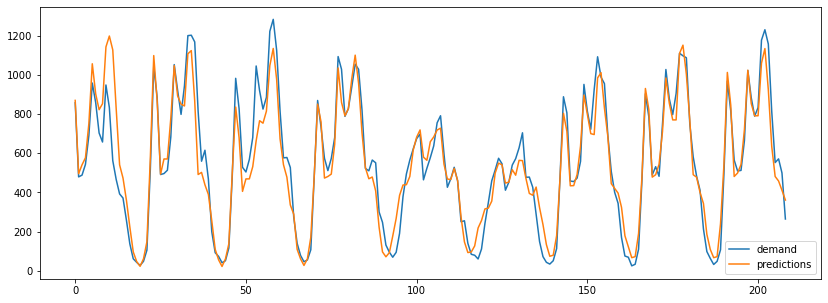

In [161]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [162]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'XGBoost with exog', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,23121.392344,89.478469,152.057201,0.810537
1,ForecastAutoreg,7723.660588,59.293636,87.884359,0.934986
2,ForecastAutoreg,8386.312352,62.880608,91.576811,0.926742
3,ForecastAutoreg,8386.312352,62.880608,91.576811,0.926742
4,ForecastAutoreg with exog. variables,10395.294518,65.325610,101.957317,0.895500
5,ForecastAutoreg with exog. variables,8589.378326,61.772859,92.678899,0.923244
6,LGBM,13962.583424,81.443799,118.163376,0.841084
7,XGBoost,13753.531199,80.988119,117.275450,0.842267
8,XGBoost,29588.740439,109.275520,172.013780,0.785130
9,XGBoost,13753.531199,80.988119,117.275450,0.842267


#### 3.3.3. Gradient Boosting: LGBMRegressor

In [94]:
#pip install lightgbm
from lightgbm import LGBMRegressor

In [95]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                              lags=[24,24*7])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor(max_depth=2, n_estimators=50) 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': 2, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 50, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-05-27 17:45:29 
Last fit date: None 
Skforecast version: 0.4.3 

In [96]:
forecaster.fit(y=y_train)
predictions = forecaster.predict(steps=len(X_test))
predictions = predictions.reset_index()
predictions = predictions['pred']
predictions

0      863.247151
1      513.366841
2      500.812631
3      571.204702
4      761.872315
          ...    
204    588.768393
205    518.183223
206    466.449226
207    420.346378
208    403.039484
Name: pred, Length: 209, dtype: float64

In [98]:
demand = y_test
demand = demand.reset_index()
demand = demand['rides']

demand

0      857
1      479
2      488
3      543
4      690
      ... 
204    813
205    552
206    571
207    499
208    264
Name: rides, Length: 209, dtype: int64

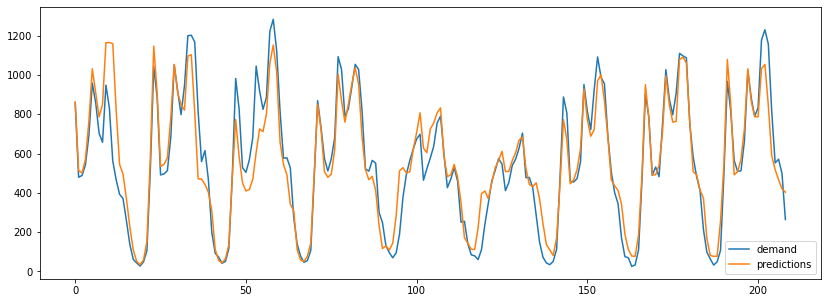

In [99]:
fig, ax = plt.subplots(figsize=(14, 5))

plt.plot(demand, label='demand')
plt.plot(predictions, label = 'predictions')
ax.legend()
plt.show()

In [100]:
mse, mae, rmse, r2 = calculate_metrics(predictions, demand)
evaluation_models = evaluation_models.append({'model':'LGBM', 'MSE': mse, 'MAE': mae, 'RMSE': rmse,  'R2':r2},
                                             ignore_index=True)
evaluation_models

,model,MSE,MAE,RMSE,R2
0,naive,23121.392344,89.478469,152.057201,0.810537
1,ForecastAutoreg,7723.660588,59.293636,87.884359,0.934986
2,ForecastAutoreg,8386.312352,62.880608,91.576811,0.926742
3,ForecastAutoreg,8386.312352,62.880608,91.576811,0.926742
4,ForecastAutoreg with exog. variables,10395.294518,65.325610,101.957317,0.895500
5,ForecastAutoreg with exog. variables,8589.378326,61.772859,92.678899,0.923244
6,LGBM,13962.583424,81.443799,118.163376,0.841084


### Hyperparameters

In [107]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(),
                              lags=[24,24*7])
forecaster

ForecasterAutoreg 
Regressor: LGBMRegressor() 
Lags: [ 24 168] 
Window size: 168 
Included exogenous: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': None, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0} 
Creation date: 2022-05-27 17:49:11 
Last fit date: None 
Skforecast version: 0.4.3 

In [113]:
len(X_train)

3967

In [109]:

param_grid = {
    'max_iter': [100,500],
    'max_depth':[3,10],
    'learning_rate':[0.01,0.1]
}

possible_lags = [24,24*7]


results_grid = grid_search_forecaster(forecaster = forecaster,
                                     y = y_train,
                                     param_grid = param_grid,
                                     lags_grid = possible_lags,
                                     steps=len(X_test),
                                     refit=False,
                                     metric = 'mean_absolute_error',
                                     initial_train_size=int(len(X_train)),
                                     return_best=True,
                                     verbose=False)

loop lags_grid:   0%|                                               | 0/2 [00:00<?, ?it/s]

Number of models compared: 16
[LightGBM] [Warning] num_iterations is set=100, max_iter=100 will be ignored. Current value: num_iterations=100


ValueError: No objects to concatenate

In [ ]:
results_grid.head(10)

In [ ]:
#Backtest with best hyperparameters
metric, predictions = backtesting_forecaster(forecaster = forecaster
                                            y = rides_per_hour_model['rides'],
                                            initial_train_size=len(X_train),
                                            steps = len(X_test),
                                            metric = 'mean_absolute_error',
                                            refit=False,
                                            verbose=True)

In [ ]:
metric

#### Adding exogenous variables: weekday and is_holiday

We saved our exogenous variables in a variable called columns_for_model

In [ ]:
columns_for_model

In [ ]:
forecaster = ForecasterAutoreg(regressor = LGBMRegressor(max_depth=2, learning_rate=0.1, n_estimators=50),
                              lags=[24,24*7])
forecaster.fit(y = X_test,
              exog = X_test[])